In [386]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

from sklearn.inspection import permutation_importance
import lightgbm as lgb

### Creation of more features

In [387]:
df_final = pd.read_feather("./data/final_data.feather")

In [388]:
df_final['1year_price_variation'] = (df_final['1year_price'] - df_final['prices_avg']) / df_final['prices_avg']
df_final['Baseline'] = df_final.groupby('asset_num')['1year_price_variation'].shift(4)
#df_final['1quarter_price_variation'] = df_final.groupby('asset_num')['prices_avg'].pct_change(1)

In [389]:
def calculate_sp500_return() -> float:
    sp500 = pd.read_csv("./data/SP500_TR.csv")
    sp500['date'] = pd.to_datetime(sp500['date']).dt.to_period('Q')
    sp500 = sp500.groupby('date').apply(lambda group: group.loc[group['date'].idxmax()]).reset_index(drop=True)
    sp500['1year_sp500_return'] = (sp500['SP500'].shift(-4) - sp500['SP500']) / sp500['SP500']
    sp500 = sp500[sp500['date'] < '2023Q4']
    return sp500[['date', '1year_sp500_return']]

sp500 = calculate_sp500_return()
sp500.head()

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\3137064614.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sp500 = sp500.groupby('date').apply(lambda group: group.loc[group['date'].idxmax()]).reset_index(drop=True)


,date,1year_sp500_return
0,2005Q1,0.057696
1,2005Q2,0.127167
2,2005Q3,0.091986
3,2005Q4,0.106072
4,2006Q1,0.157942


In [390]:
df_final = df_final.merge(sp500, left_on='quarter', right_on='date', how='left').drop(columns='date')
df_final['asset_return_diff_sp500'] = df_final['1year_price_variation'] - df_final['1year_sp500_return']
df_final['asset_return_gt_sp500'] = df_final['asset_return_diff_sp500'] > 0

Creating new features related to the EV or oter features features and deleting original ones, p.e.: ebit, ebitda, net income, revenue.

In [391]:
df_final['EV_EBITDA'] = df_final['ev'] / df_final['ebitda']
df_final['EV_EBIT'] = df_final['ev'] / df_final['ebit']
df_final['P_B_ratio'] = df_final['prices_avg'] / (df_final['T_assets'] - df_final['T_debt'])

df_final['Debt_to_Equity'] = df_final['T_debt'] / (df_final['T_assets'] - df_final['T_debt'])
df_final['Net_Debt_to_EBITDA'] = df_final['net_debt'] / df_final['ebitda']

df_final['Asset_Turnover'] = df_final['T_rev'] / df_final['T_assets']
df_final['Cash_Conversion_Ratio'] = df_final['cash'] / df_final['T_rev']

In [392]:
irrelevant_features = ['cap_ex', 'cash', 'ebit', 'ebitda', 'net_inc', 'T_assets', 'T_debt', 'T_rev']
df_final = df_final.drop(columns=irrelevant_features, errors='ignore')

# Handle missing or infinite values
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

In [404]:
info_cols = ['asset_num','quarter','sector','survivor','prices_avg','1year_price','prices_std','1year_price_variation','1year_sp500_return','asset_return_diff_sp500']
target_col = 'asset_return_gt_sp500'
df_final['new_sector'] = df_final['new_sector'].astype('category')

feature_cols = [col for col in df_final.columns if col not in info_cols + [target_col]]
print(df_final[feature_cols].isna().sum())

dil_shares                245
new_sector                  0
ebit_marg                2541
ebitda_marg              2590
net_marg                  352
ROA                       363
ROE                       363
debts_assets              354
net_debt                  388
cash_ratio               1496
net_income_per_share      498
price_earning_ratio       499
ev                        537
Baseline                 1524
EV_EBITDA                2766
EV_EBIT                  2719
P_B_ratio                 354
Debt_to_Equity            354
Net_Debt_to_EBITDA       2632
Asset_Turnover            363
Cash_Conversion_Ratio     397
dtype: int64


### Creation of the dataset partitions to train the model

In [406]:
df_final['quarter'] = df_final['quarter'].astype('str')
df_final = df_final[~df_final['quarter'].isin(['2005Q1','2005Q2','2005Q3','2005Q4'])]

In [407]:
unique_quarters = df_final['quarter'].astype('str').unique()
unique_quarters

array(['2006Q1', '2006Q2', '2006Q3', '2006Q4', '2007Q1', '2007Q2',
       '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3', '2008Q4',
       '2009Q1', '2009Q2', '2009Q3', '2009Q4', '2010Q1', '2010Q2',
       '2010Q3', '2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4',
       '2012Q1', '2012Q2', '2012Q3', '2012Q4', '2013Q1', '2013Q2',
       '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3', '2014Q4',
       '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
       '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4',
       '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2',
       '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4',
       '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1', '2022Q2',
       '2022Q3', '2022Q4', '2023Q1', '2023Q2', '2023Q3'], dtype=object)

In [408]:
def prepare_train_test_data(dataset: pd.DataFrame, quarters_col: str, features: list[str], target: str, window_size:int=10) -> list[Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]]:
    
    data = dataset.sort_values(by=quarters_col)
    unique_quarters = data[quarters_col].unique()
    datasets = {}

    
    for i in range(len(unique_quarters) - window_size):
        train_quarters = unique_quarters[i:i + window_size]
        test_quarter = unique_quarters[i + window_size]
        
        train_data = data[data[quarters_col].isin(train_quarters)]
        test_data = data[data[quarters_col] == test_quarter]
        

        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]
        
        datasets[str(test_quarter)] = (X_train, y_train, X_test, y_test)
        
    return datasets

In [409]:
window_size = 20
datasets = prepare_train_test_data(df_final, 'quarter', feature_cols, target_col, window_size=window_size)

In [410]:
def return_learning_curve(results:dict, set_:str) -> pd.DataFrame:
    learning_curves = pd.DataFrame()
    for quarter in results:
        learning_curve = pd.DataFrame(results[(quarter)][set_])
        learning_curve["n_trees"] = list(range(len(learning_curve)))
        learning_curve["quarter"] = quarter
        learning_curves= pd.concat([learning_curves,learning_curve])
        
    for column in learning_curves.columns:
        if column not in ["n_trees","quarter"]:        
            first_metric = learning_curves[[column,"quarter"]].drop_duplicates(["quarter"])
            first_metric = first_metric.rename(columns = {column:"first_"+column})
            learning_curves = pd.merge(learning_curves,first_metric,on = ["quarter"])
            learning_curves["norm_"+column] = (learning_curves[column] - learning_curves["first_"+column] )/learning_curves["first_"+column]
            learning_curves = learning_curves.drop(columns = "first_"+column)
    learning_curves["quarter"] = learning_curves["quarter"].astype(str)
    
    return learning_curves

### Searching for the best hyperparameters

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


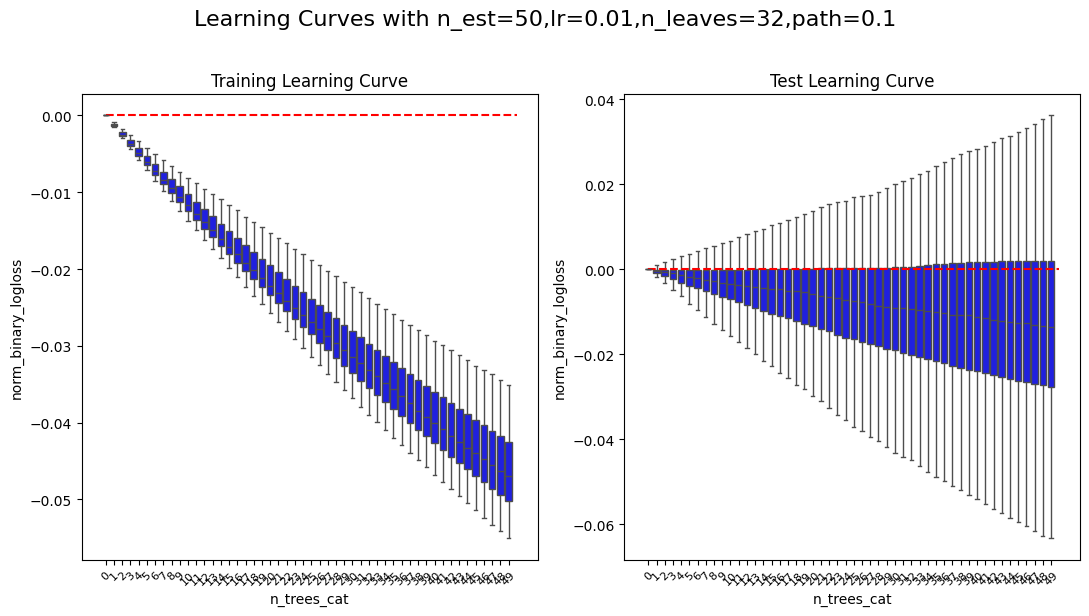

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


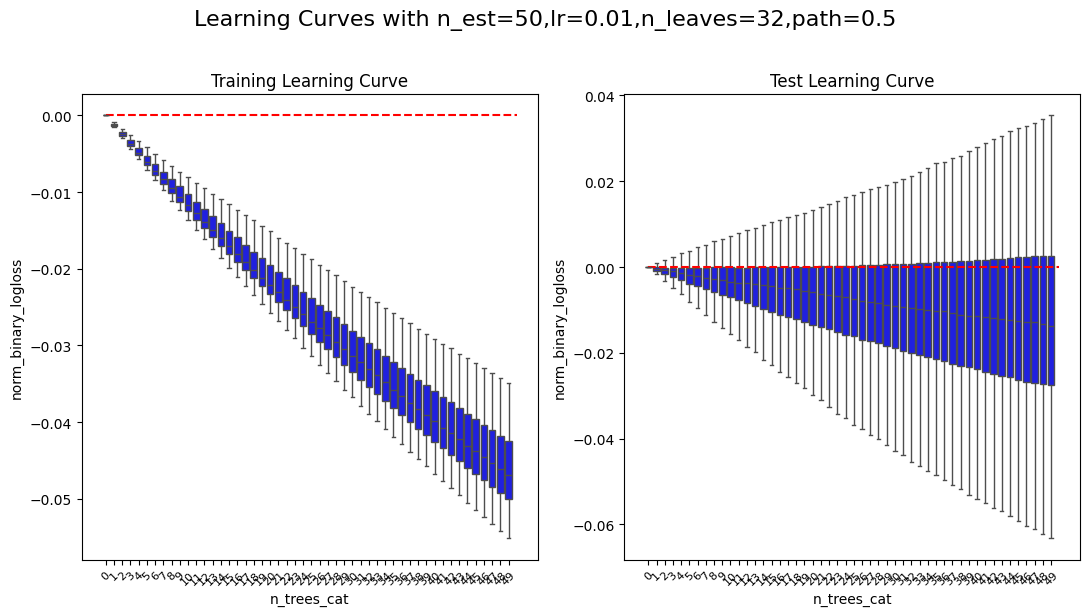

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


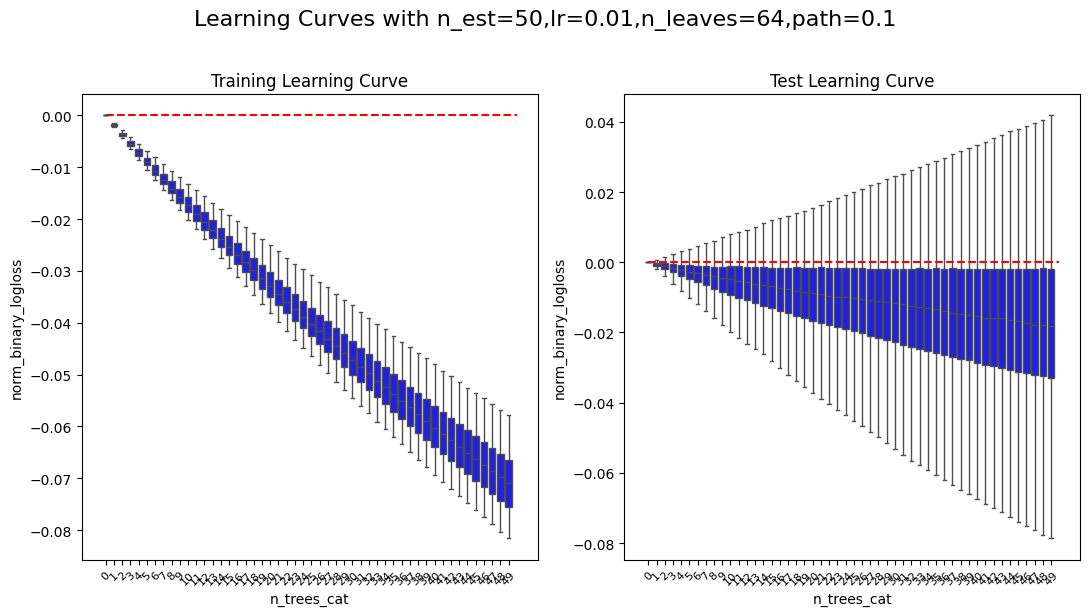

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


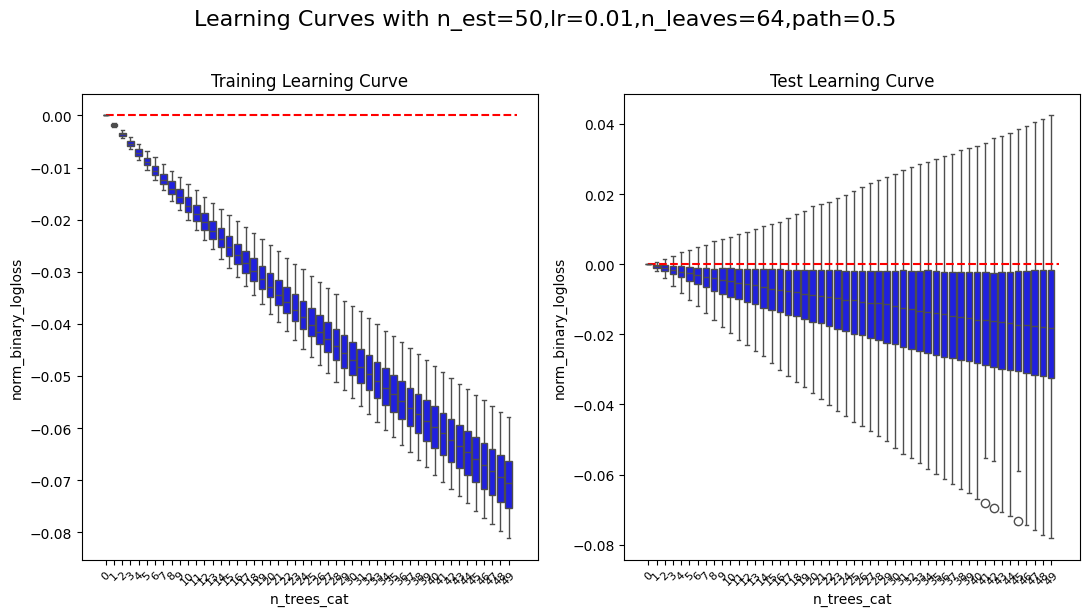

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


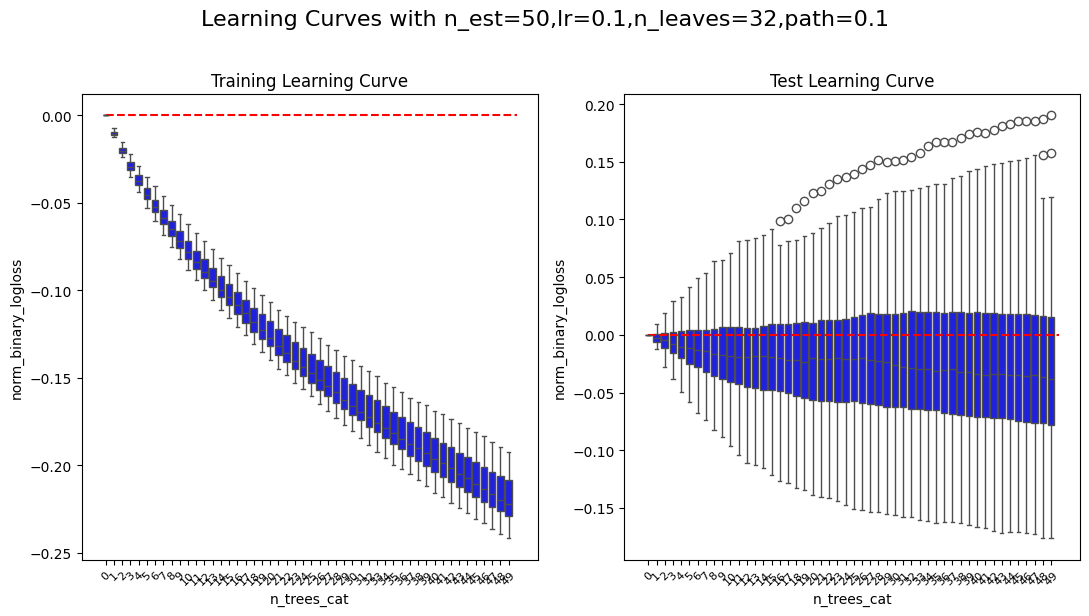

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


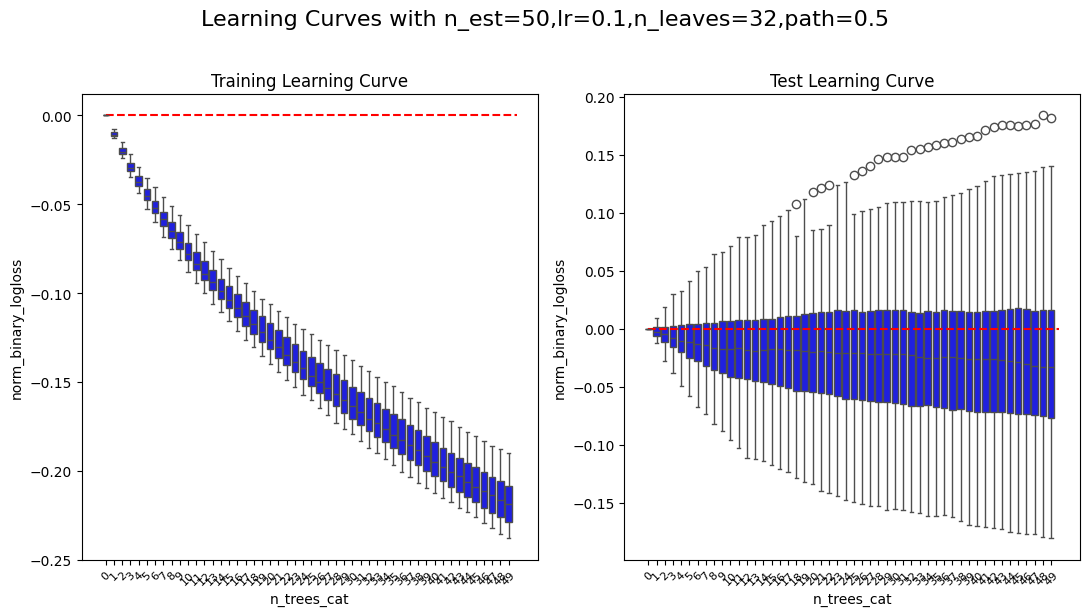

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


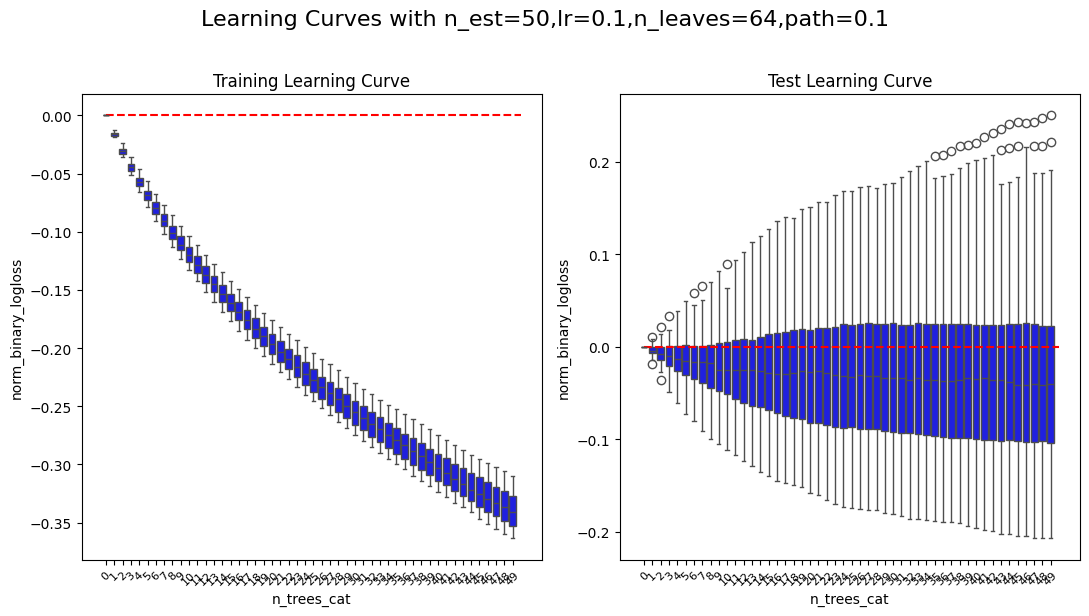

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


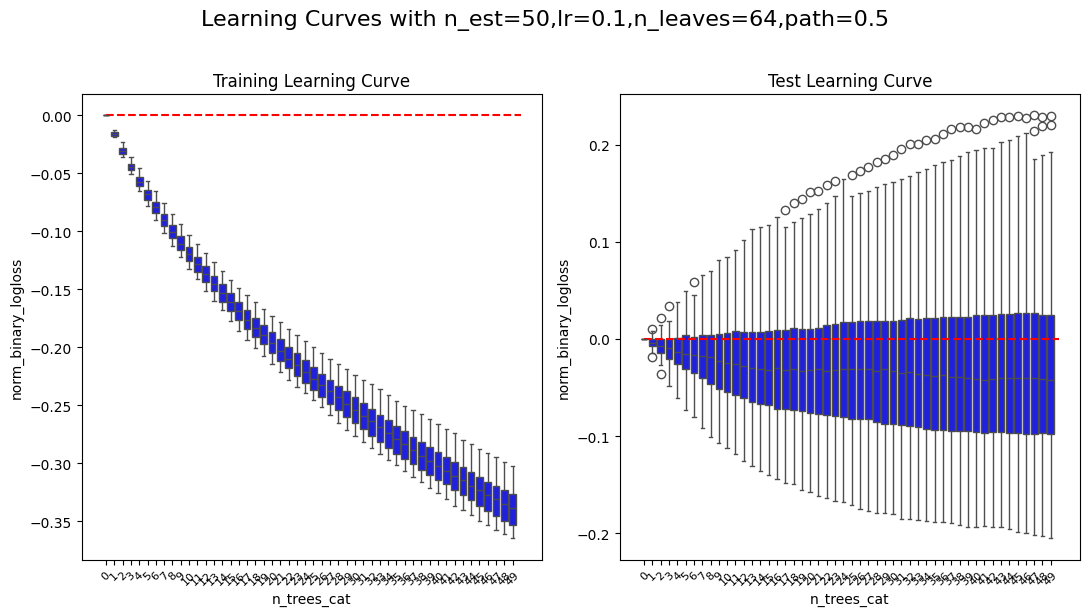

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


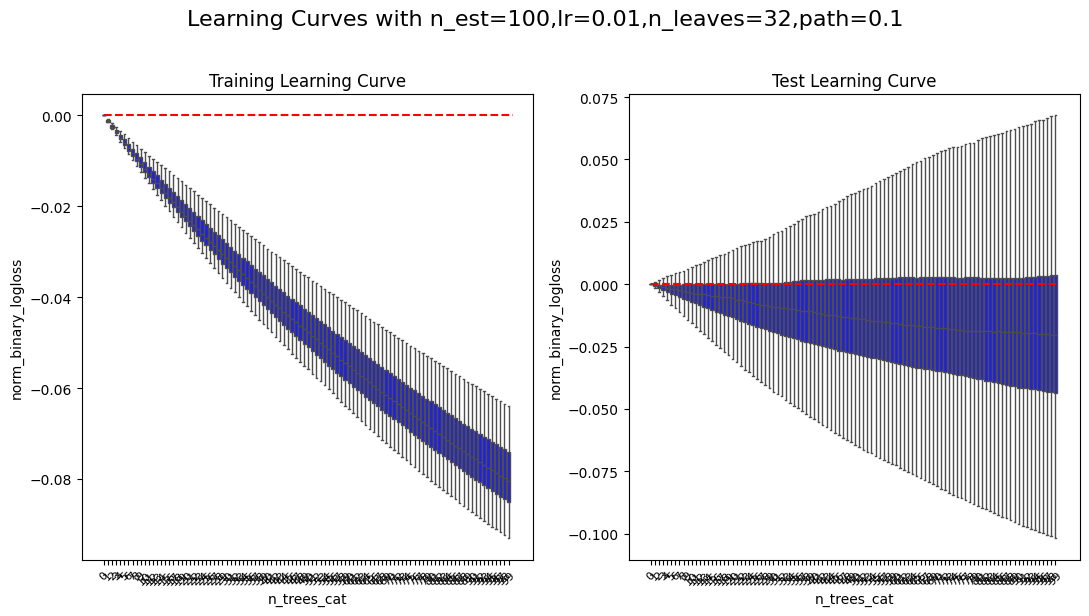

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


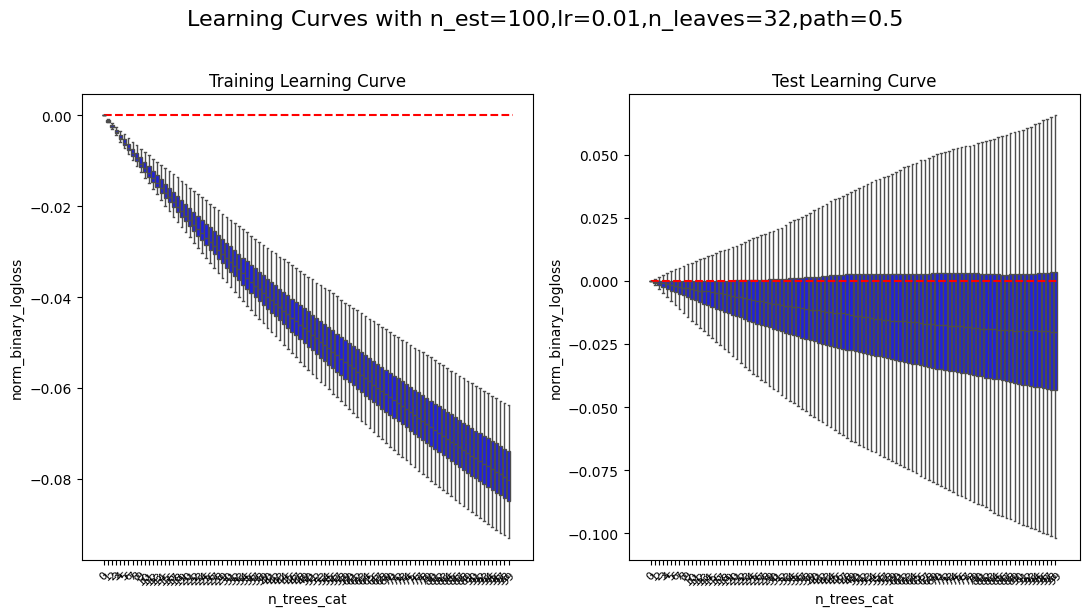

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


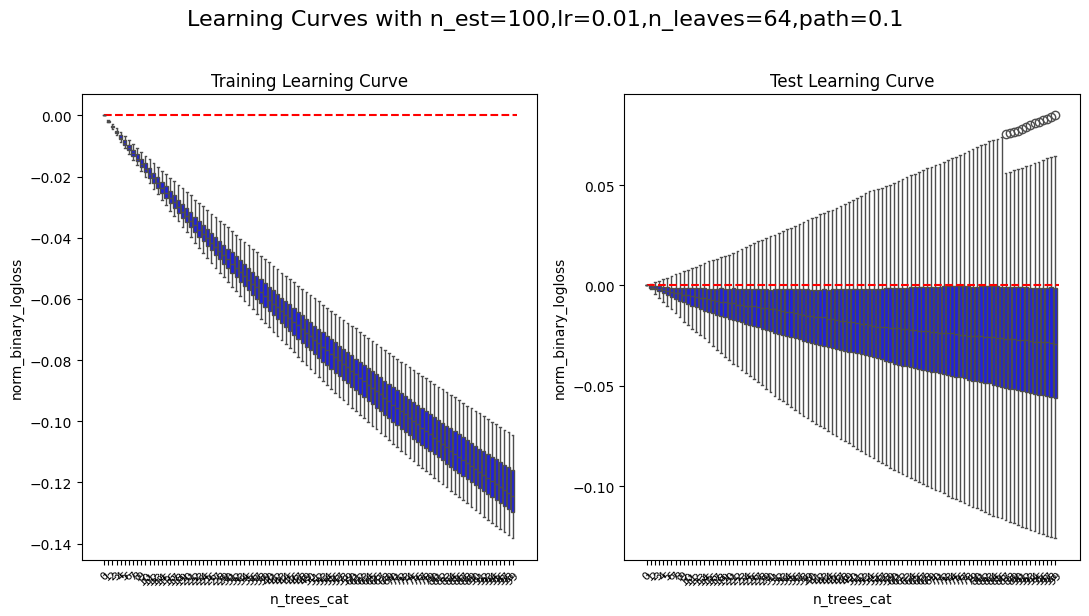

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


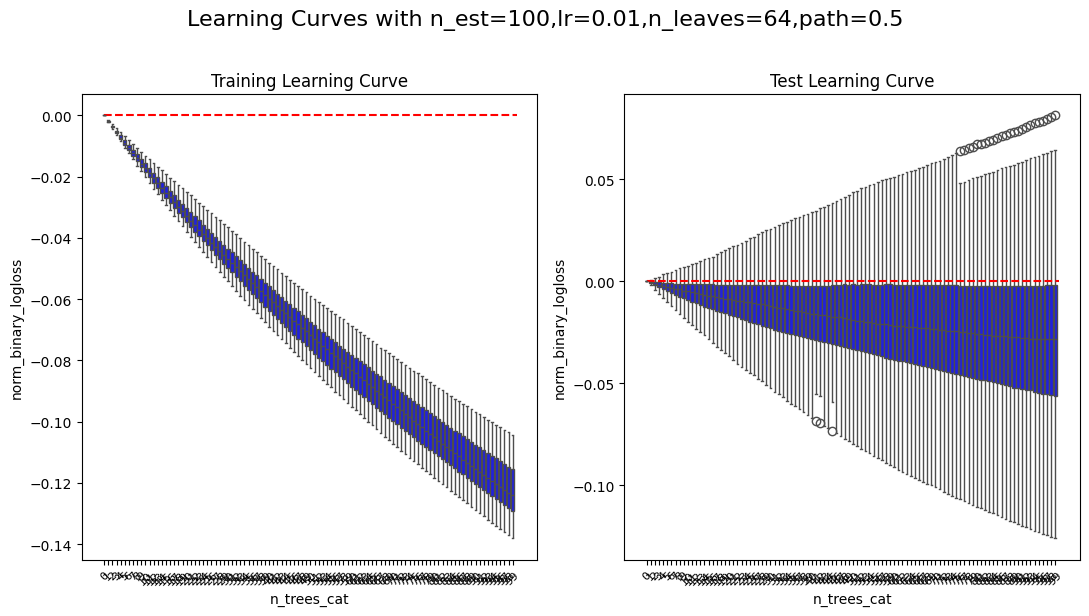

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


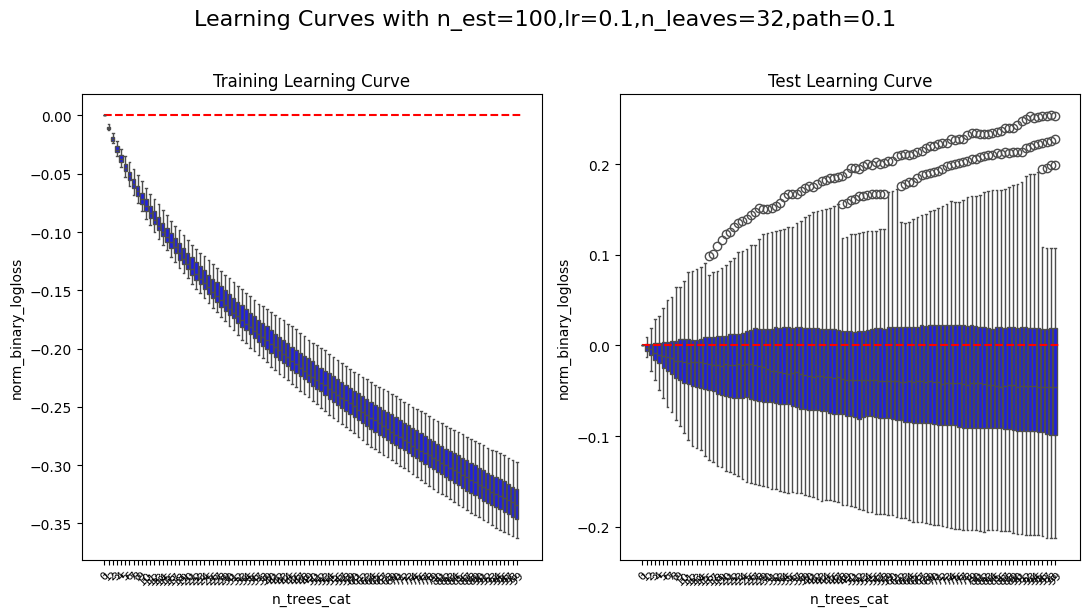

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


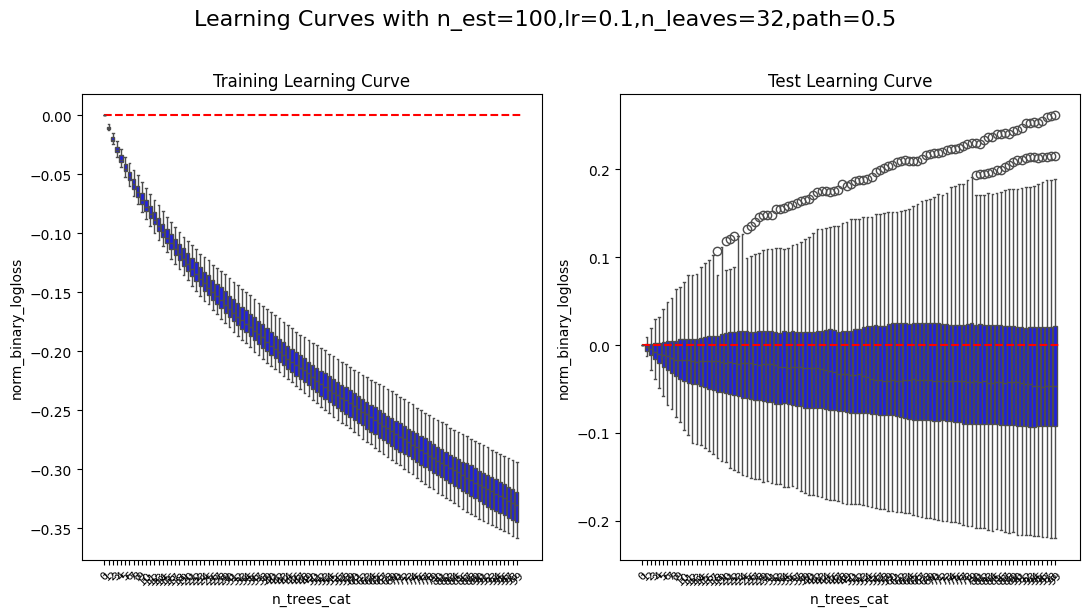

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


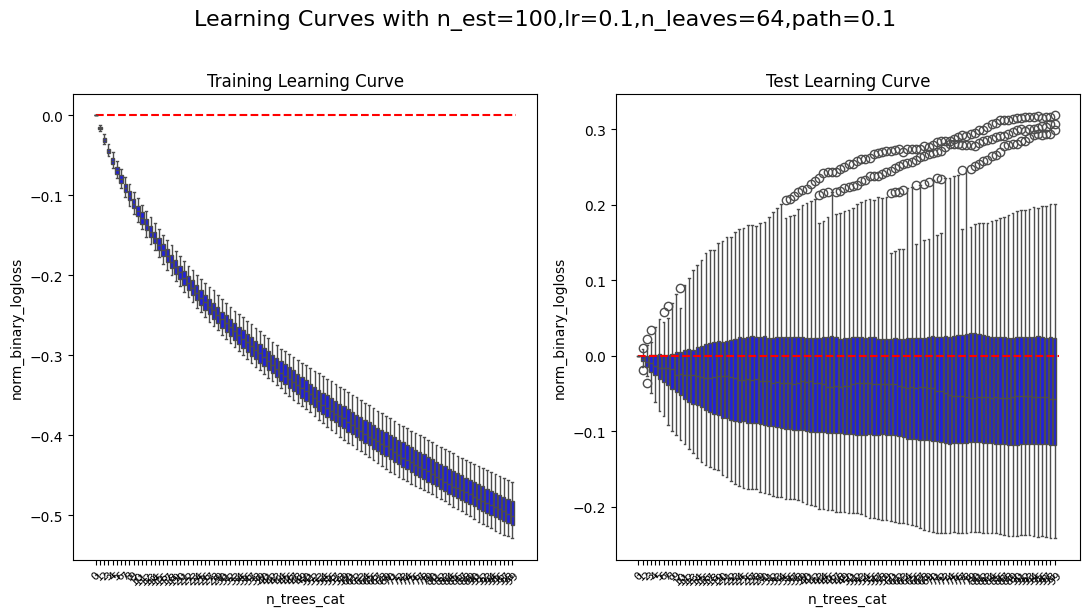

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\844387219.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


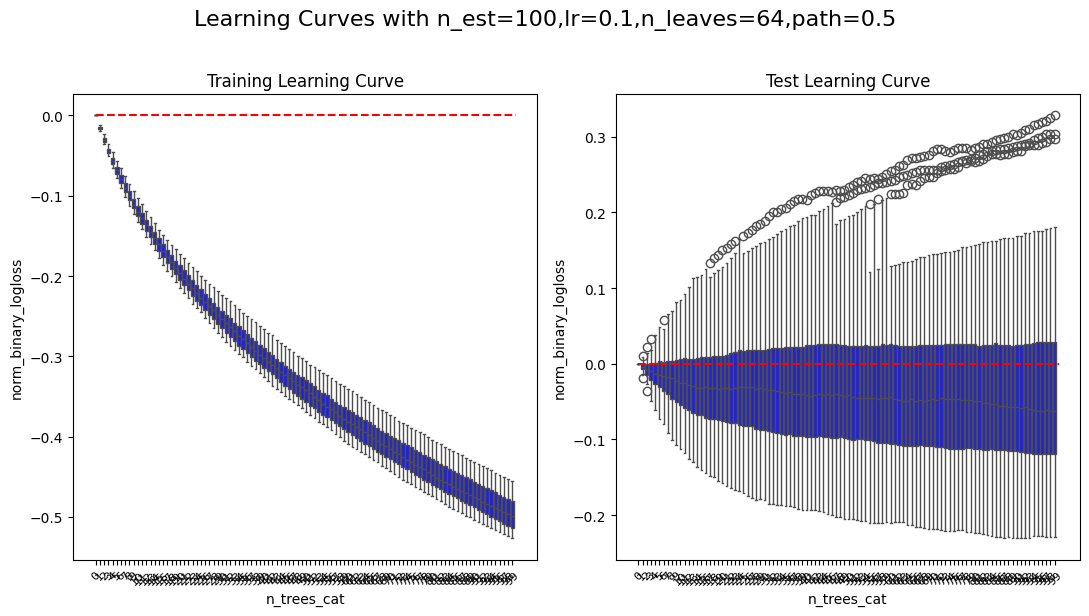

In [412]:
# This code is commented to avoid running it by mistake but it is left here to show the results
params_lgb = {
    'metric': 'logloss',
    'random_state': 1,
    'verbose': 0,
    'n_estimators': 50,
    'learning_rate': 0.01,
    'num_leaves': 32,
    'path_smooth': 0.1
}


for n_estimators in [50, 100]:
    for learning_rate in [0.01, 0.1]:
        for num_leaves in [32, 64]:
            for path_smooth in [0.1, 0.5]:
                params_lgb = {
                    'metric': 'logloss',
                    'random_state': 1,
                    'verbose': 0,
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'num_leaves': num_leaves,
                    'path_smooth': path_smooth
                }
                
                models_list = {}
                results_list = {}
                predictions_list = {}
                compute_importance = True
                permut_importances_list = {}
                categorical_features = ['new_sector']

                for i in range(len(datasets)):
                    test_quarter = unique_quarters[i + window_size]
                    #print(f"Training model to test quarter: {test_quarter}")

                    X_train, y_train, X_test, y_test = datasets[unique_quarters[i+window_size]]

                    eval_result = {}

                    model = lgb.LGBMClassifier(**params_lgb)

                    model.fit(
                        X_train, y_train,
                        categorical_feature=categorical_features,
                        eval_set=[(X_test, y_test), (X_train, y_train)],
                        eval_metric='logloss',
                        callbacks=[lgb.record_evaluation(eval_result=eval_result)]
                    )
                    
                    results_list[(test_quarter)] = eval_result


                test_lc = return_learning_curve(results_list,"valid_0")
                train_lc = return_learning_curve(results_list,"training")

                train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
                test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))



                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

                sns.boxplot(data=train_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue', ax=ax1)
                ax1.hlines(0, 0, len(train_lc['n_trees'].unique()), color='red', linestyle='--')
                ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
                ax1.set_title('Training Learning Curve')

                sns.boxplot(data=test_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue', ax=ax2)
                ax2.hlines(0, 0, len(test_lc['n_trees'].unique()), color='red', linestyle='--')
                ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)
                ax2.set_title('Test Learning Curve')

                plt.suptitle(f'Learning Curves with n_est={n_estimators},lr={learning_rate},n_leaves={num_leaves},path={path_smooth}', fontsize=16, y=1.02)

                plt.tight_layout()  
                plt.savefig(f'./data/learning_curves/lc_{n_estimators}_{learning_rate}_{num_leaves}_{path_smooth}.png',dpi=300, bbox_inches='tight')
                plt.show()

After comparing the learning curves, we choose the model with Lr = 0.01, n_leaves = 64, path_smooth = 0.1 or 0.5, and n_estimators = 100.

In [413]:
params_lgb = {
    'objective': 'binary',
    'metric': 'logloss',
    'random_state': 1,
    'verbose': 0,
    'n_estimators': 100,
    'learning_rate': 0.01,
    'num_leaves': 64,
    'path_smooth': 0.5
}



models_list = {}
results_list = {}
predictions_list = {}
compute_importance = True
permut_importances_list = {}
categorical_features = ['new_sector']

for i in range(len(datasets)):
    test_quarter = unique_quarters[i + window_size]
    print(f"Training model to test quarter: {test_quarter}")
    
    X_train, y_train, X_test, y_test = datasets[unique_quarters[i+window_size]]
    
    eval_result = {}
    
    model = lgb.LGBMClassifier(**params_lgb)
    
    model.fit(
        X_train, y_train,
        categorical_feature=categorical_features,
        eval_set=[(X_test, y_test), (X_train, y_train)],
        eval_metric='logloss',
        callbacks=[lgb.record_evaluation(eval_result=eval_result)]
    )
    
    if compute_importance:
        r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)
        feature_names = X_test.columns
        df_permutation_importance = pd.DataFrame({'importance': r.importances_mean, 'feature': feature_names})
    else:
        df_permutation_importance = pd.DataFrame()
    
    
    models_list[(test_quarter)] = model
    results_list[(test_quarter)] = eval_result
    predictions_list[(test_quarter)] = model.predict_proba(X_test)[:,1]
    permut_importances_list[(test_quarter)] = df_permutation_importance

Training model to test quarter: 2011Q1
Training model to test quarter: 2011Q2
Training model to test quarter: 2011Q3
Training model to test quarter: 2011Q4
Training model to test quarter: 2012Q1
Training model to test quarter: 2012Q2
Training model to test quarter: 2012Q3
Training model to test quarter: 2012Q4
Training model to test quarter: 2013Q1
Training model to test quarter: 2013Q2
Training model to test quarter: 2013Q3
Training model to test quarter: 2013Q4
Training model to test quarter: 2014Q1
Training model to test quarter: 2014Q2
Training model to test quarter: 2014Q3
Training model to test quarter: 2014Q4
Training model to test quarter: 2015Q1
Training model to test quarter: 2015Q2
Training model to test quarter: 2015Q3
Training model to test quarter: 2015Q4
Training model to test quarter: 2016Q1
Training model to test quarter: 2016Q2
Training model to test quarter: 2016Q3
Training model to test quarter: 2016Q4
Training model to test quarter: 2017Q1
Training model to test qu

In [414]:
test_lc = return_learning_curve(results_list,"valid_0")
train_lc = return_learning_curve(results_list,"training")

train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

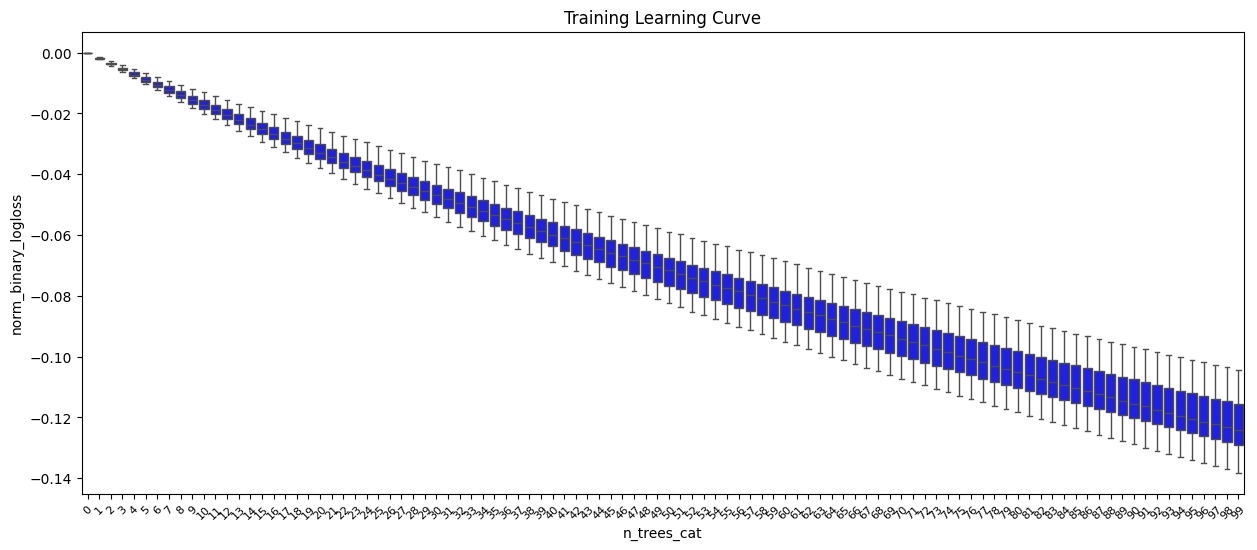

In [415]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=train_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue')
plt.xticks(rotation=45, fontsize=8)
plt.title('Training Learning Curve')
plt.show()

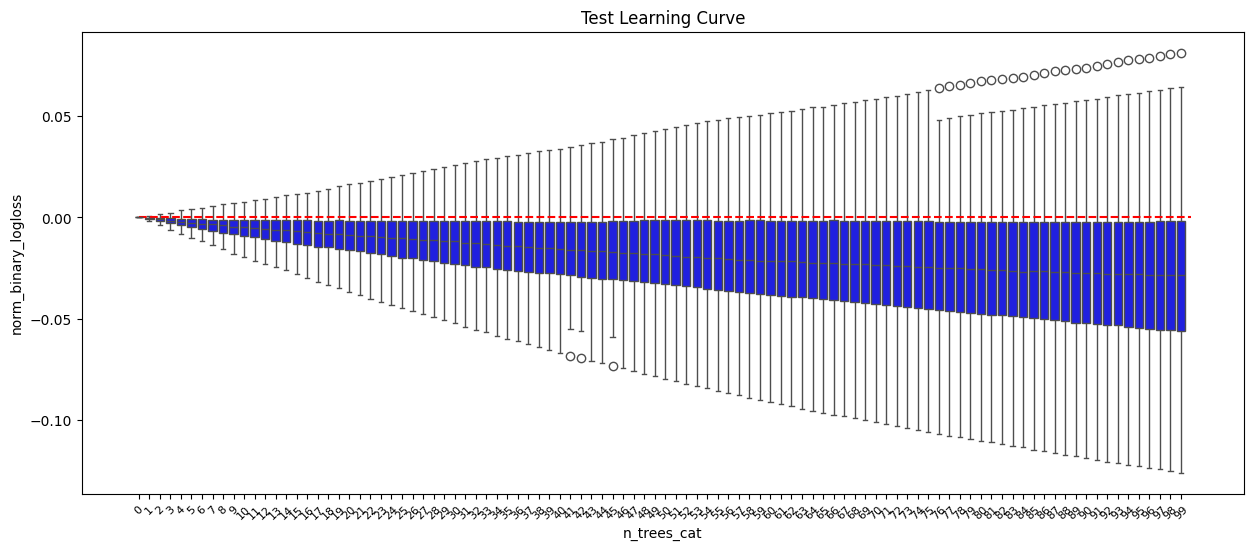

In [423]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=test_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue')
plt.hlines(0, 0, len(test_lc['n_trees'].unique()), color='red', linestyle='--')
plt.xticks(rotation=45, fontsize=8)
plt.title('Test Learning Curve')
plt.show()

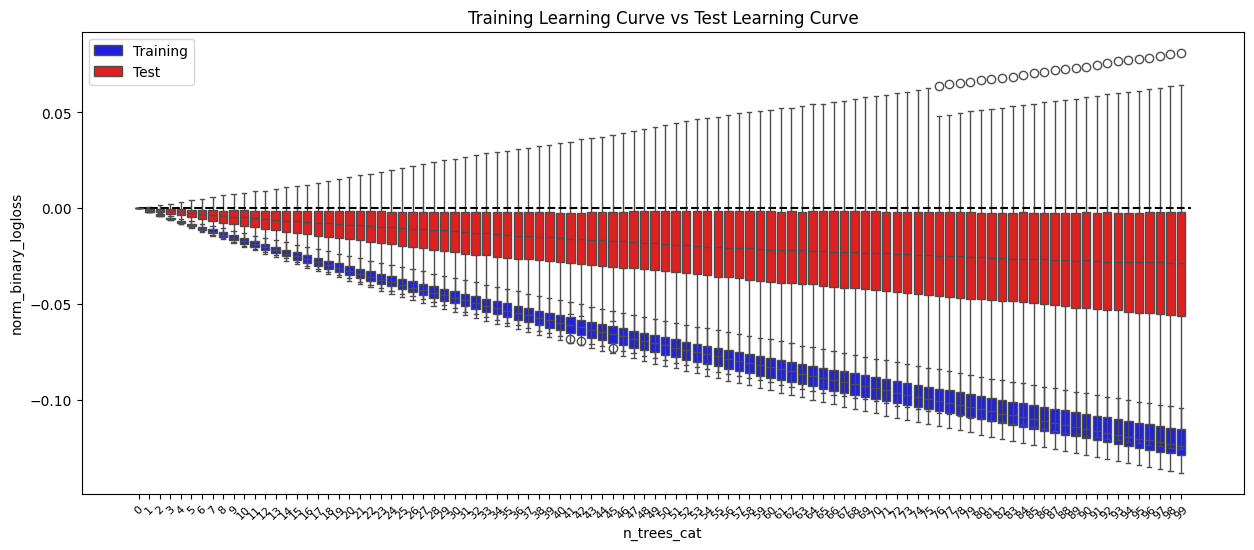

In [425]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=train_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue', label='Training')
sns.boxplot(data=test_lc, x='n_trees_cat', y='norm_binary_logloss', color='red', label='Test')
plt.hlines(0, 0, len(test_lc['n_trees'].unique()), color='black', linestyle='--')
plt.xticks(rotation=45, fontsize=8)
plt.title('Training Learning Curve vs Test Learning Curve')
plt.legend()
plt.show()

In [426]:
importance_dfs = []

# Generate a DataFrame for each quarter with the permutation importances
for quarter, df_imp in permut_importances_list.items():
    df_imp['quarter'] = quarter
    df_imp['importance'] = df_imp['importance']
    importance_dfs.append(df_imp)

df_importances = pd.concat(importance_dfs, ignore_index=True)

df_importances

,importance,feature,quarter
0,0.039092,dil_shares,2011Q1
1,0.050881,new_sector,2011Q1
2,0.016870,ebit_marg,2011Q1
3,0.018225,ebitda_marg,2011Q1
4,0.013753,net_marg,2011Q1
...,...,...,...
1066,0.001613,P_B_ratio,2023Q3
1067,0.007392,Debt_to_Equity,2023Q3
1068,-0.000336,Net_Debt_to_EBITDA,2023Q3
1069,0.006653,Asset_Turnover,2023Q3


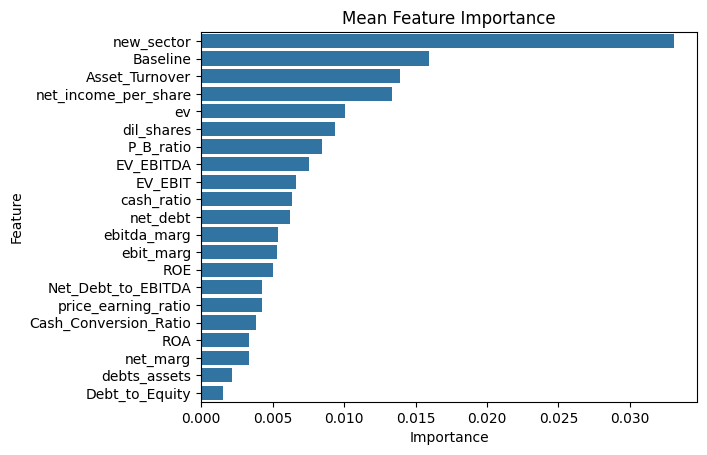

In [427]:
df_importances_mean = df_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)
sns.barplot(x=df_importances_mean, y=df_importances_mean.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Mean Feature Importance')
plt.show()

In [428]:
df_importances_sorted = df_importances.sort_values(by=['quarter','importance'], ascending=[True,False]).reset_index(drop=True)
df_importances_sorted["rank"] = df_importances_sorted.groupby(["quarter"]).cumcount()
r_all_permutation_importances = df_importances_sorted[df_importances_sorted["rank"]<3]

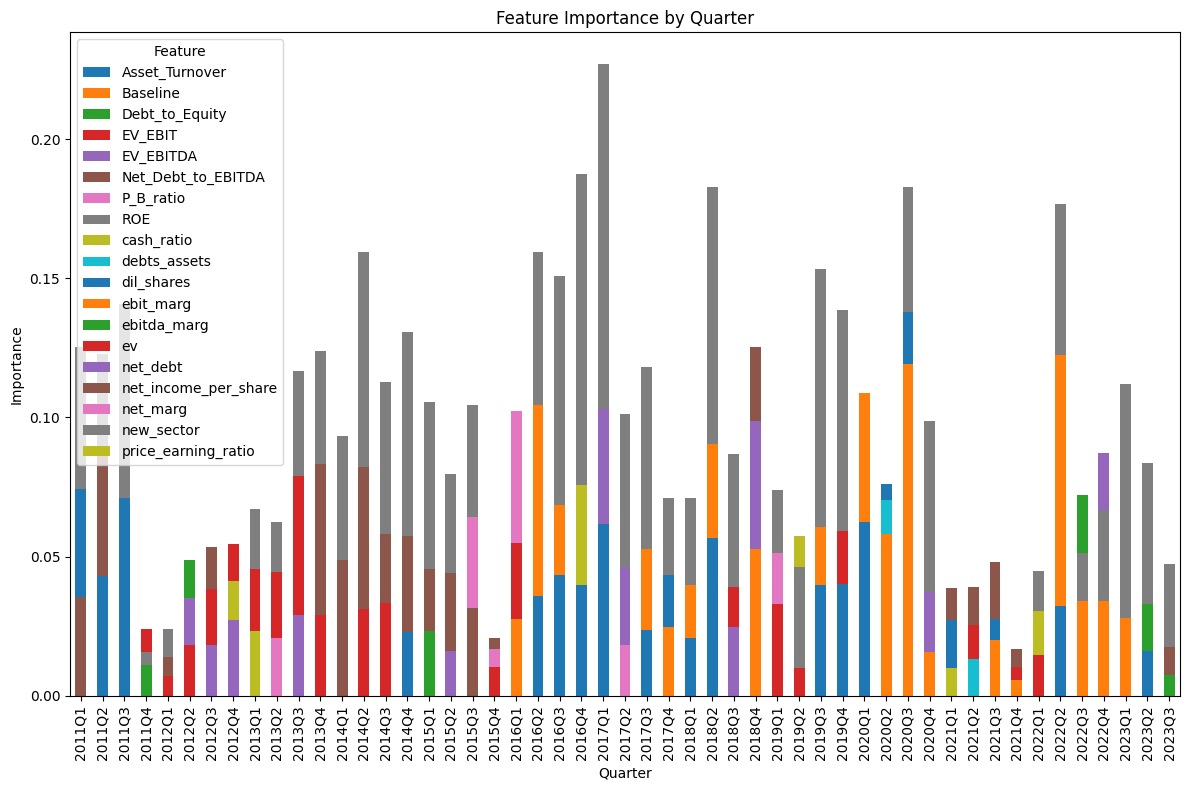

In [429]:
pivot_df = r_all_permutation_importances.pivot(index="quarter", columns="feature", values="importance")

pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 8),
)
plt.xlabel("Quarter")
plt.ylabel("Importance")
plt.title("Feature Importance by Quarter")
plt.legend(title="Feature")
plt.tight_layout()

plt.show()

### Comparing predictions with SP500

In [431]:
def create_results_df(predictions: dict,quarter:str,sector:str=False, versus_sp500:bool = True ) -> pd.DataFrame:
    assets = df_final[df_final['quarter'] == quarter]['asset_num']
    df = pd.DataFrame(assets).reset_index(drop=True)
    df['prediction'] = predictions[quarter]
    df['asset_num'] = assets.values
    df['rank_pos'] = df['prediction'].rank(ascending=False)
    df['rank_neg'] = df['prediction'].rank(ascending=True)
    if versus_sp500:
        df = df.merge(df_final[df_final['quarter'] == quarter][['asset_num','asset_return_gt_sp500','asset_return_diff_sp500']], on='asset_num')
    else:
        df = df.merge(df_final[df_final['quarter'] == quarter][['asset_num','1year_price_variation','1year_sp500_return']], on='asset_num')    
    if sector:
        df = df.merge(df_final[df_final['quarter'] == quarter][['asset_num','Baseline','new_sector']], on='asset_num')
    else:
        df = df.merge(df_final[df_final['quarter'] == quarter][['asset_num','Baseline']], on='asset_num')
    return df

In [432]:
def equitative_return(df:pd.DataFrame, n:int) -> pd.DataFrame:
    df = df.sort_values('rank_pos', ascending=False).head(n)
    return df['asset_return_diff_sp500'].mean()

In [540]:
def calculate_returns(sector_df:str=False,n_assets:int = 20) -> pd.DataFrame:
    prediction_returns_eq = []
    baseline_returns = []
    sector_returns = []
    sector_list = []
    quarter_list = []
    for i in range(len(datasets)):
        quarter = unique_quarters[i+window_size] 
        if sector_df:
            df = create_results_df(predictions_list, quarter,True)
            for sector in df['new_sector'].unique():
                df_sector = df[df['new_sector'] == sector]
                return_sector = df_sector['asset_return_diff_sp500'].mean()
                sector_returns.append(return_sector)
                sector_list.append(sector)
                return_prediction_equitative = equitative_return(df_sector, n_assets)
                prediction_returns_eq.append(return_prediction_equitative- return_sector)
                return_baseline = df_sector.sort_values('Baseline', ascending=False).head(n_assets)['asset_return_diff_sp500'].mean()
                baseline_returns.append(return_baseline- return_sector)
                
                quarter_list.append(quarter)
        else:
            df = create_results_df(predictions_list, quarter)
            return_prediction_equitative = equitative_return(df, n_assets)
            return_baseline = df.sort_values('Baseline', ascending=False).head(n_assets)['asset_return_diff_sp500'].mean()
            prediction_returns_eq.append(return_prediction_equitative)
            baseline_returns.append(return_baseline)
    
    if sector_df:
        return pd.DataFrame({'quarter': quarter_list, 'sector': sector_list,
                         'prediction_return_equitative': prediction_returns_eq,  
                         'baseline_return': baseline_returns, 'sector_return': sector_returns})
    else: 
        return pd.DataFrame({'quarter': unique_quarters[window_size:], 
                         'prediction_return_equitative': prediction_returns_eq,  
                         'baseline_return': baseline_returns})

In [558]:
n_assets = 20
df_returns_quarters = calculate_returns(n_assets=n_assets)

At the graph, we can see for each quarter the difference between the return of the prediction and the return of the SP500. We take also the difference between Baseline and SP500 to compare with the prediction model.

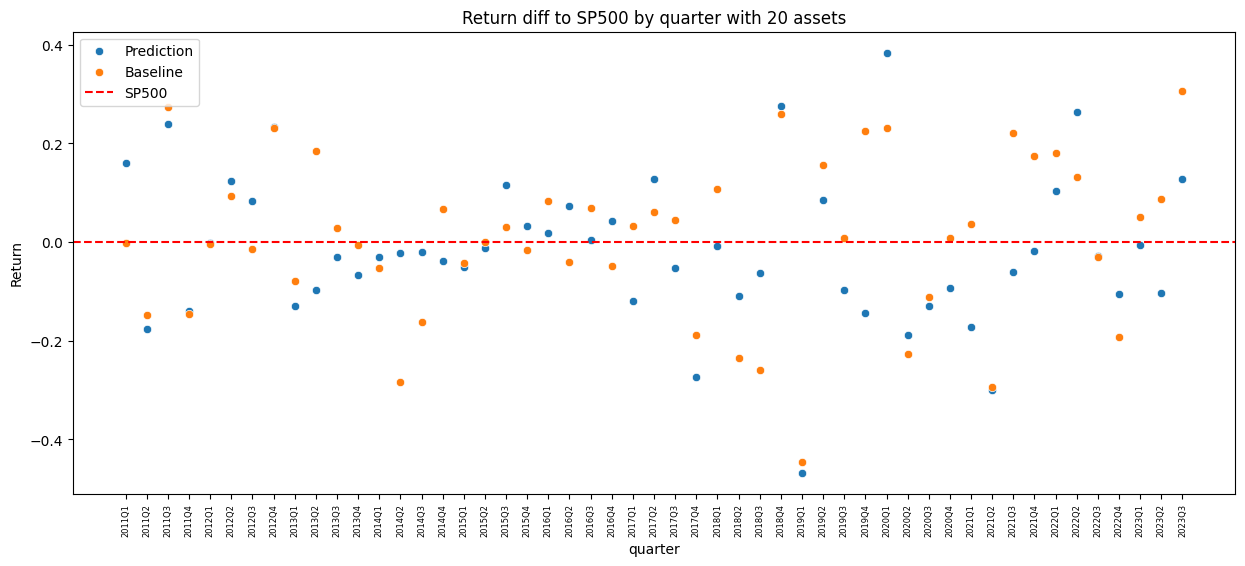

In [559]:
plt.subplots(figsize=(15, 6))
sns.scatterplot(data=df_returns_quarters, x='quarter', y='prediction_return_equitative',label='Prediction')
sns.scatterplot(data=df_returns_quarters, x='quarter', y='baseline_return',label='Baseline')
plt.axhline(y=0.0, color='r', linestyle='--', label='SP500')
plt.title(f'Return diff to SP500 by quarter with {n_assets} assets')
plt.ylabel('Return')
plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.show()

### Comparing predictions versus the return of the market for each sector

For each quarter, and sector, we will calculate the return of the model for the top 20 assets compared to the return of the sector

In [560]:
n_assets = 20
sector_returns = calculate_returns(sector_df=True,n_assets=n_assets)

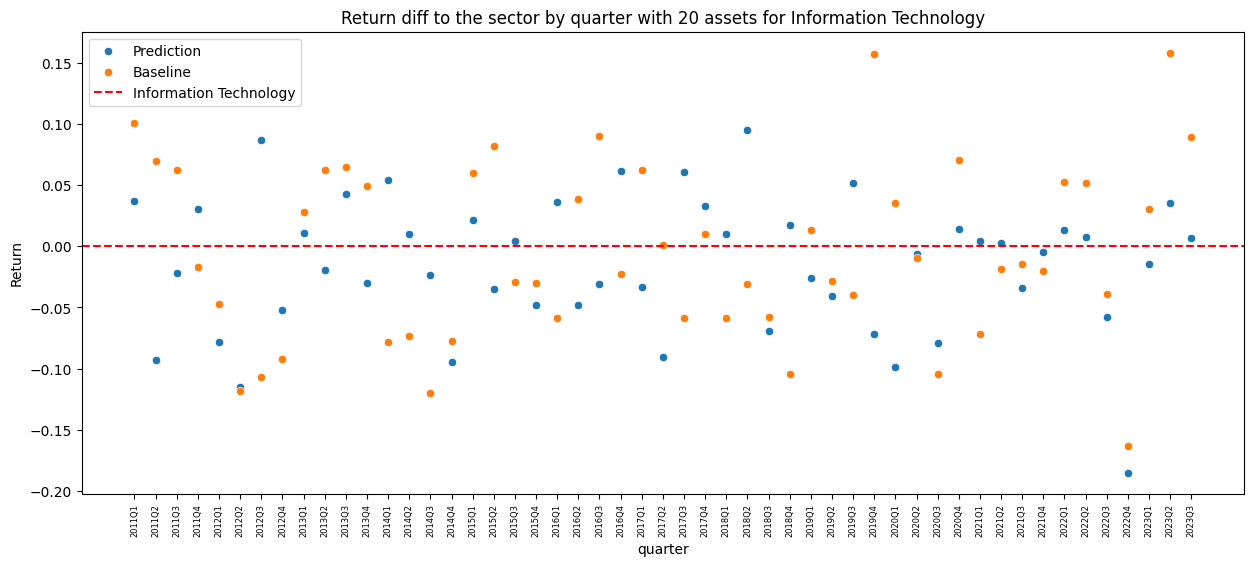

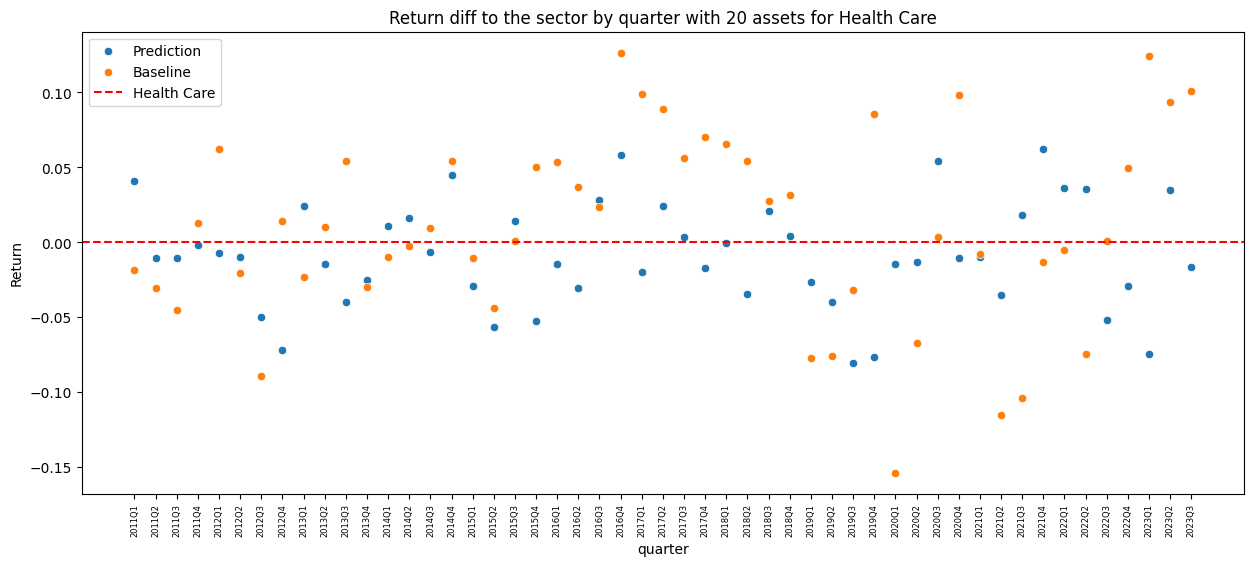

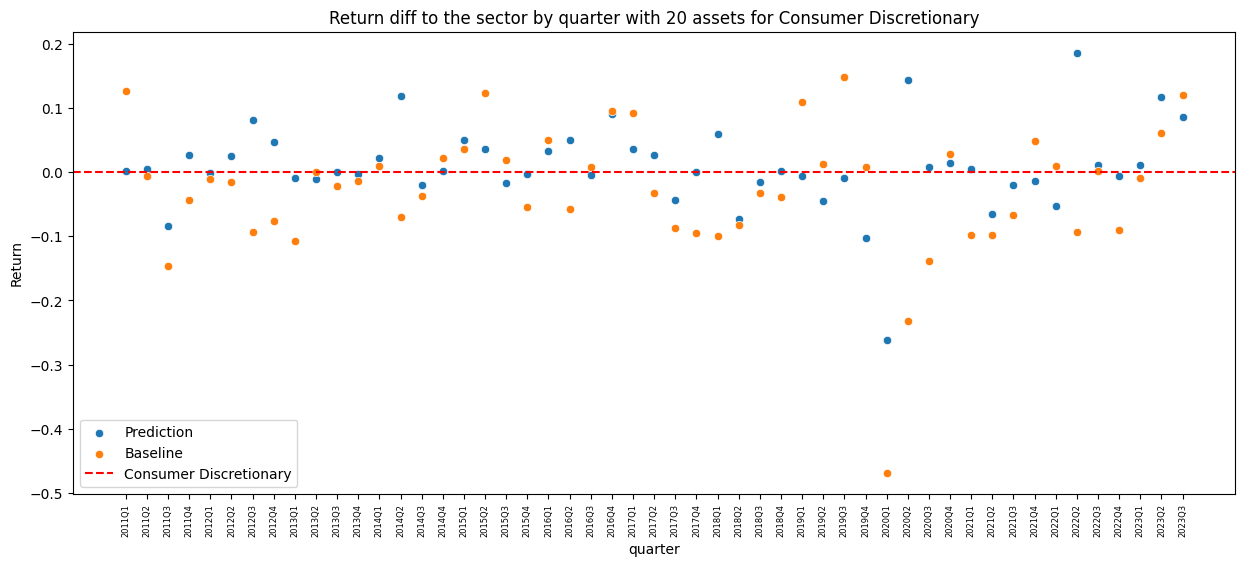

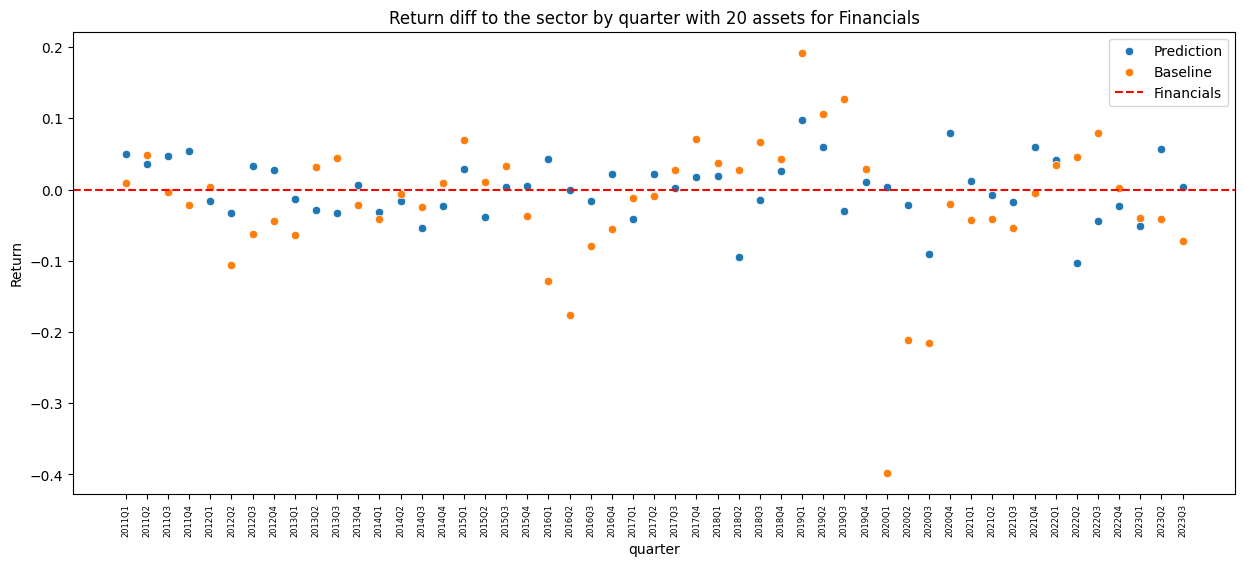

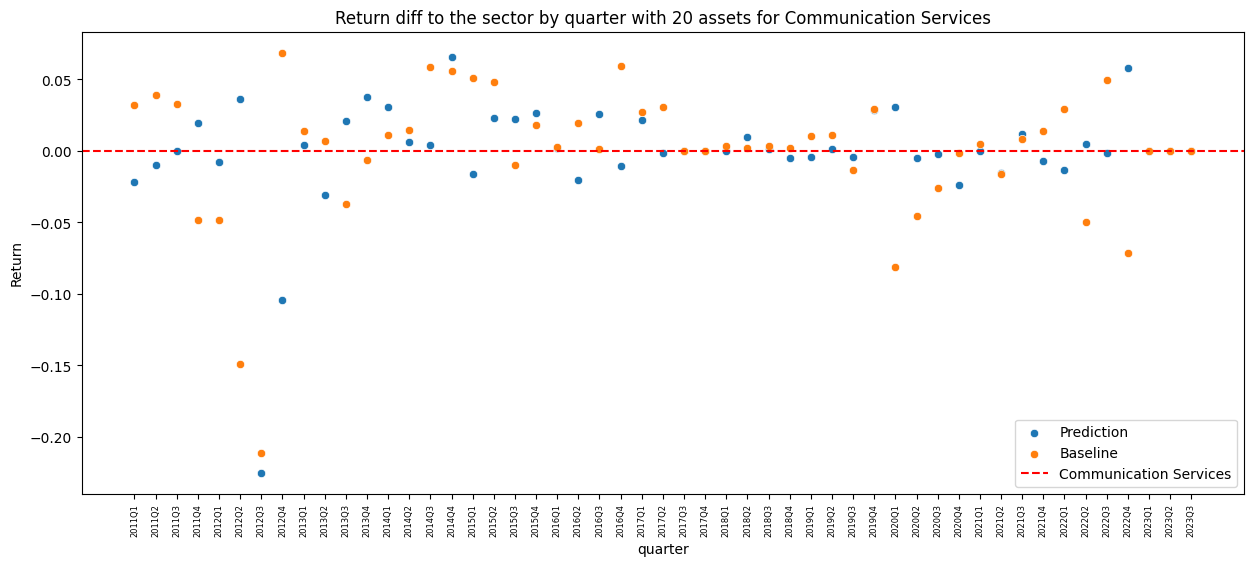

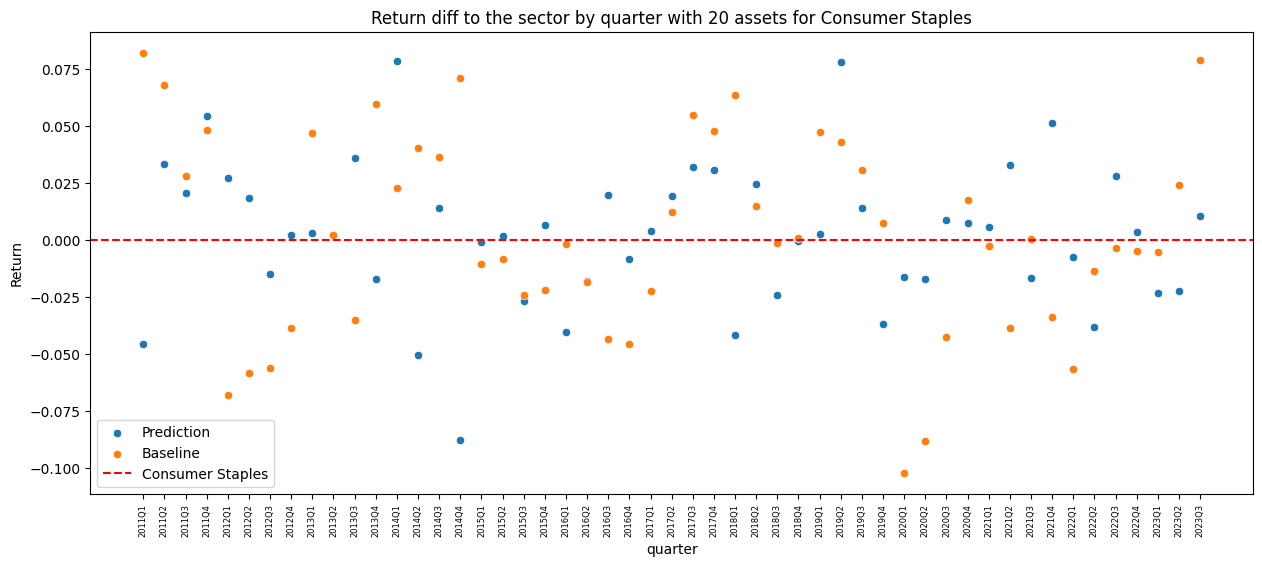

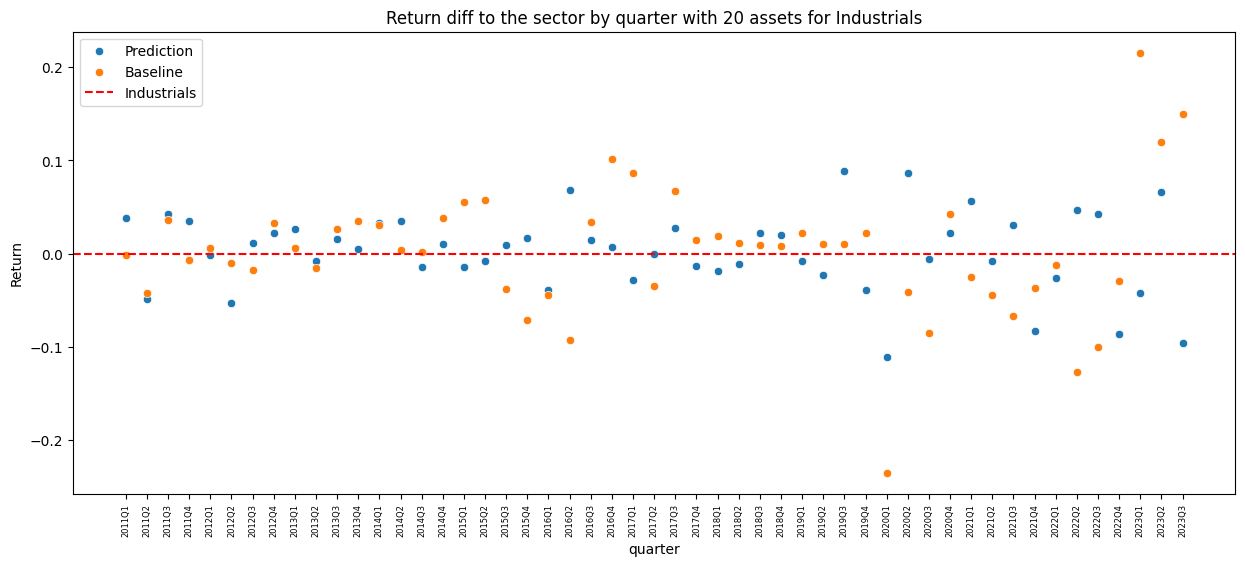

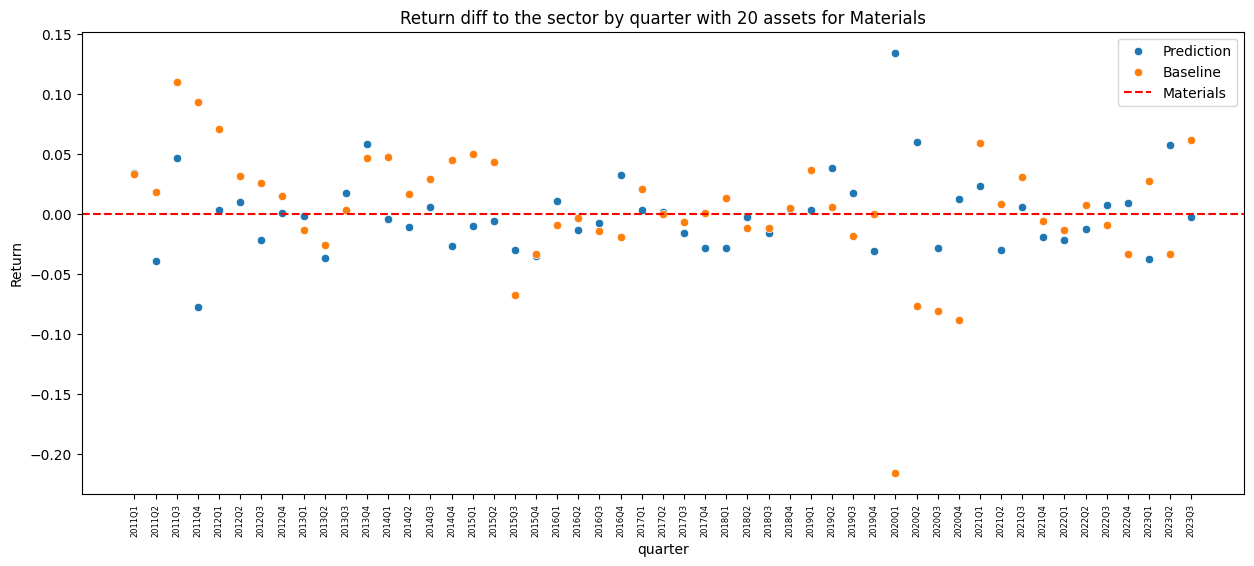

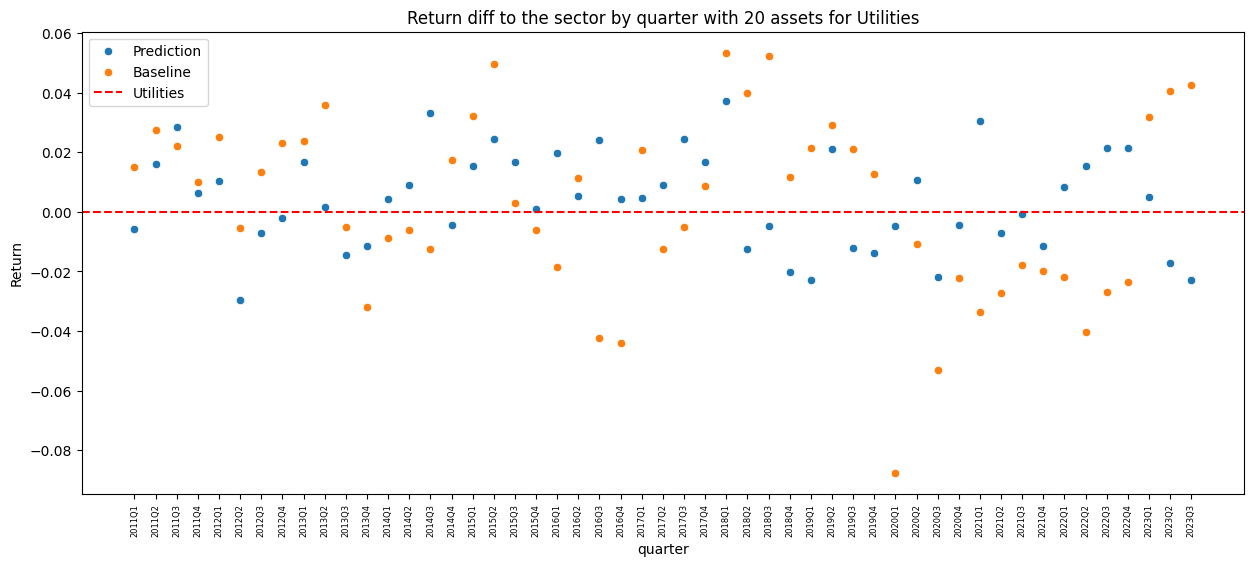

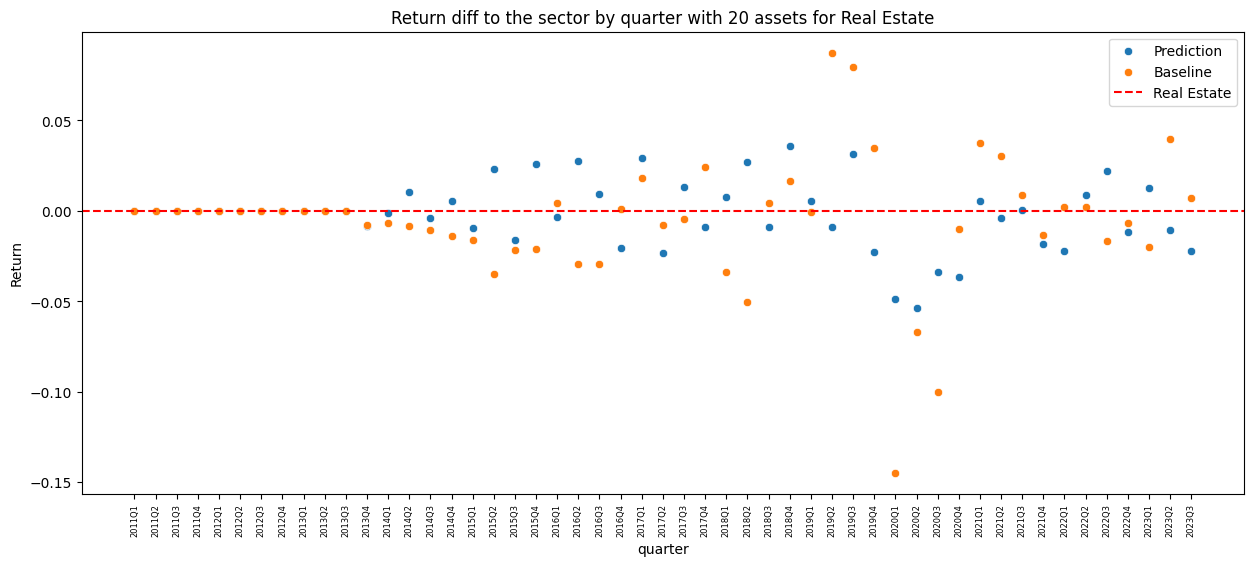

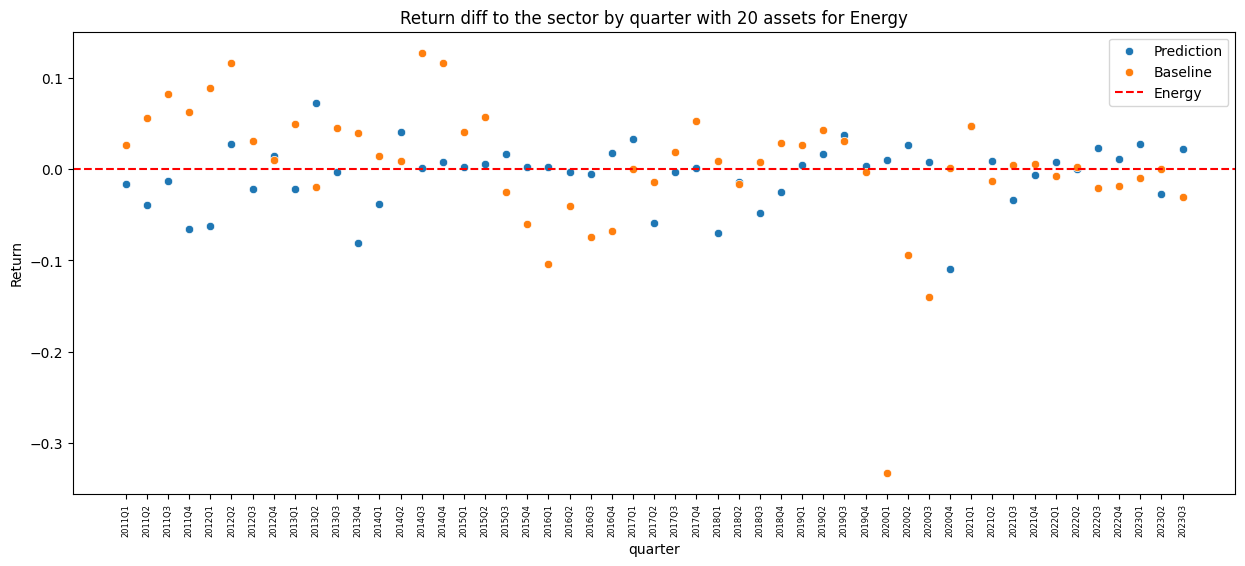

In [561]:
for sector in sector_returns['sector'].unique():
    df_sector = sector_returns[sector_returns['sector'] == sector]
    plt.subplots(figsize=(15, 6))
    sns.scatterplot(data=df_sector, x='quarter', y='prediction_return_equitative',label='Prediction')
    sns.scatterplot(data=df_sector, x='quarter', y='baseline_return',label='Baseline')
    plt.axhline(y=0.0, color='r', linestyle='--', label=sector)
    plt.title(f'Return diff to the sector by quarter with {n_assets} assets for {sector}')
    plt.ylabel('Return')
    plt.xticks(rotation=90, fontsize=6)
    plt.legend()
    plt.show()